## 1/f and Attention: Examining the Relationship Between Attention and Aperiodic Neural Activity in Resting-State EEG in Ageing

Created by Toomas Erik Anijärv in 02.12.2022 (edited: 18.04.2023)

This notebook is a representation of EEG processing done for the publication with one of the participants as an example.

You are free to use this or any other code from this repository for your own projects and publications. Citation or reference to the repository is not required, but would be much appreciated (see more on README.md).

In [1]:
import mne, os
import seaborn as sns
import warnings
import numpy as np
import pingouin as pg
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum, plot_spectrum_shading
import HLR

# Set the current working directory to be the project main folder
os.chdir('/Users/tanijarv/Documents/GitHub/EEG-pyline')

import basic.arrange_data as arrange
import signal_processing.pre_process as pre_process
import signal_processing.spectral_analysis as spectr

**Locating the EEG files in folders** by define the experiment sub-folder (`exp_folder`), folder with raw EEG files (`raw_folder`), folder for exporting clean EEG files (`clean_folder`), and folder for exporting the results (`results_folder`).

During pre-processing, all the raw EEG files are cleaned from the `raw_folder/exp_folder` and later saved to `clean_folder/exp_folder`. For analysis, the same clean files are read in and worked on until the results are exported to `results_folder/exp_folder`.

In [2]:
### DEFINE ###
raw_folder = 'Data/Raw/'
clean_folder = 'Data/Clean/'
spectra_folder = 'Data/Spectra/'
results_folder = 'Results/'
savefinal_folder = 'Results/LEISURE/'

exp_folder = 'LEISURE/T1/EC'
exp_condition = 'EC_T1'

### PRE-PROCESSING

**Pre-processing** within this study includes initially reading the raw EEG files from `raw_folder/exp_folder`, setting montage (`biosemi32`), re-referencing the signals to `mastoid`, cropping the EEG signal to include only the `resting` part.

Furthermore, `0.5-30 Hz FIR filter` is designed (`zero-phase, Hamming window, order 6578`) and EOG channels are used to remove EOG-related noise with `signal-space projections (SSP)` as method.

Finally, artefacts are rejected with Autoreject package by removing epochs which exceed the global thereshold voltage level (`global AR`) and rest of the artefactual epochs are either removed or interpreted with `local AR`.

The clean EEG signals are exported to `clean_folder/exp_folder`.

In [ ]:
### DEFINE ###
montage = 'biosemi32'
eog_channels = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8'] # EOG channels + mastoids
stimulus_channel = 'Status'
reference = 'average' # average as reference
epochs_duration = 5
filter_design = dict(l_freq=0.5,h_freq=30,filter_length='auto',method='fir',
                     l_trans_bandwidth='auto',h_trans_bandwidth='auto',
                     phase='zero',fir_window='hamming',fir_design='firwin')

# Set the directory in progress and find all BDF (raw EEG) files in there
dir_inprogress = os.path.join(raw_folder,exp_folder)
export_dir = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress,'.bdf')

In [ ]:
for i in range(len(file_dirs)):
    # Read in the raw EEG data
    raw = mne.io.read_raw_bdf(file_dirs[i], infer_types=True, eog=eog_channels,
                              stim_channel=stimulus_channel).drop_channels(['Erg1'])

    # Set the right montage (Biosemi32) and set reference as average across all channels
    raw = raw.set_montage(mne.channels.make_standard_montage(montage)).load_data()\
             .set_eeg_reference(ref_channels=reference, verbose=True)

    # Find event markers for the start and end of resting state recordings
    events = mne.find_events(raw, stim_channel=stimulus_channel, consecutive=False, output='offset')
    # If there is 3 events, then crop the signal by the first and last event point
    if len(events) >= 3:
        tminmax = [events[0][0]/raw.info['sfreq'], events[-1][0]/raw.info['sfreq']]
        # If there is more than 3, warn the user (as probably requires manual processing)
        if len(events) > 3:
            warnings.warn('\nMore than 3 event points found for {}\n'.format(subject_names[i]))
    # If there is 1 or 2 event points, check whether they are start or end points or similar to each
    elif len(events) == 1 or len(events) == 2:
        warnings.warn('\nOnly 1 or 2 event point(s) found for {}\n'.format(subject_names[i]))

        if events[0][0] > 100000:
            tminmax = [0, events[0][0]/raw.info['sfreq']]
        else:
            tminmax = [events[0][0]/raw.info['sfreq'], None]
    else:
        tminmax = None
        warnings.warn('\nNO event points found for {}\n'.format(subject_names[i]))

    # Use the markers to crop to EEG signal to leave only the actual resting state
    if tminmax != None:
        cropped_raw = raw.crop(tmin=tminmax[0], tmax=tminmax[1])
        print(('Event markers are following:\n{}\nStarting point: {} s\nEnding point: {} s\n'
        'Total duration: {} s').format(events, tminmax[0], tminmax[1], tminmax[1]-tminmax[0]))
        # Warn if signal length is not what it is expected for a single condition
        if (230 <= tminmax[1]-tminmax[0] <= 250) != True:
            warnings.warn('\nRaw signal length is not between 230-250s for {}\n'.format(subject_names[i]))
    else:
        cropped_raw = raw
        print('Signal NOT cropped.')
    cropped_raw = cropped_raw.drop_channels(stimulus_channel)
    
    # Filter the signal with bandpass filter and remove EOG artefacts with SSP
    filt = pre_process.filter_raw_data(cropped_raw, filter_design, line_remove=None,
                                       eog_channels=eog_channels, plot_filt=False, savefig=False)

    # Divide the filtered signal to epochs and run Autoreject artefact rejection on the epochs
    %matplotlib inline
    epochs = pre_process.artefact_rejection(filt, subject_names[i], epo_duration=epochs_duration)

    # (Optional) for displaying interactive EEG plots to visually inspect the signal quality
    #%matplotlib qt
    #epochs.plot(n_channels=32,n_epochs=1)

    # Try to create a directory and save the EEG file to that directory
    try:
        os.makedirs(export_dir)
    except FileExistsError:
        pass
    try:
        mne.Epochs.save(epochs,fname='{}/{}_clean-epo.fif'.format(export_dir,subject_names[i]),
                                                                  overwrite=True)
    except FileExistsError:
        pass

### SPECTRAL ANALYSIS (aperiodic and alpha activity)

**Spectral analysis** within this study includes estimating `Welch's power spectrum density (PSD)` for all the participants at one global brain region. The PSDs are fitted with `specparam` (`FOOOF`) model to estimate aperiodic 1/f-like component in the spectra which can be described with parameters `exponent` and `offset`. After that, the spectrum is flattened by substracting aperiodic component from the spectrum and within the given alpha band (`7-14 Hz`), a maximum power value, i.e. peak, is detected and its amplitude (i.e. `alpha power width`) and frequency (i.e. `alpha center frequency`) are exported. Finally, `absolute alpha band power` is calculated from the flattened spectrum by averaging PSD estimate within the center frequency and its bandwidth of 6 Hz (e.g., CF=10.4Hz -> alpha band=7.4-13.4Hz) and `relative alpha band power` is calculated by dividing the absolute band power by the broadband power (i.e., average PSD across all spectrum).

Welch's PSD is calculated for `1-30 Hz` frequency range using `2.5-second Hamming window (50% overlap)` and 39 times the window (97.5 seconds) zero-padding (for more interpolated frequency points when finding center frequency of the alpha peak).

The FOOOF (specparam) algorithm (version 1.0.0) was used to parameterize neural power spectra. Settings for the algorithm were set as: `peak width limits : 1-12 Hz`; `max number of peaks : infinite`; `minimum peak height : 0.225 uV^2`; `peak threshold : 2.0 uV^2`; and `aperiodic mode : fixed`. Power spectra were parameterized across the frequency range `1-30 Hz`. The aperiodic 1/f-like fit is described with the following function, where $S$ is aperiodic component, $b$ is `offset`, $F$ is vector of frequencies, and $e$ is `exponent`:

$S=b-log(F^e)$

The results are saved as Excel spreadsheets regionally to `results_folder/exp_folder/FOOOF`.

In [ ]:
### DEFINE ###
bands = {'Alpha' : [7, 14]}
brain_regions = {'Global' : ['Fp1', 'AF3', 'F3', 'FC1', 'Fp2', 'AF4', 'F4', 'FC2', 'Fz',
                             'F7', 'FC5', 'T7', 'C3', 'F8', 'FC6', 'T8', 'C4', 'Cz',
                             'CP5', 'P3', 'P7', 'CP6', 'P4', 'P8', 'CP1', 'CP2', 'Pz',
                             'PO3', 'PO4', 'O1', 'O2', 'Oz']}
flat_spectr_scale = 'linear'
plot_rich = True
savefig = True
savespectrum = False
psd_params = dict(method='welch', fminmax=[1, 30], window='hamming', window_duration=2.5,
                  window_overlap=0.5, zero_padding=39)
fooof_params = dict(peak_width_limits=[1,12], max_n_peaks=float("inf"), min_peak_height=0.225,
                    peak_threshold=2.0, aperiodic_mode='fixed')

spectrum_name = psd_params['method']+'_'+str(psd_params['fminmax'][0])+'-'+str(psd_params['fminmax'][1])+'Hz_WIN='+str(
                psd_params['window_duration'])+'s_'+psd_params['window']+'_OL='+str(psd_params['window_overlap']*
                100)+'%_ZP='+str(psd_params['zero_padding']*psd_params['window_duration'])+'s'

sns.set_palette('muted')
sns.set_style("whitegrid")

In [ ]:
# Set the directory in progress and find all FIF (clean EEG) files in there
dir_inprogress = os.path.join(clean_folder, exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress, '_clean-epo.fif')
arrange.create_results_folders(exp_folder=exp_folder, results_folder=results_folder, fooof=True)

if savespectrum == True:
    try:
        os.makedirs(os.path.join('{}/{}/{}'.format(spectra_folder, exp_folder, spectrum_name)))
    except FileExistsError:
        pass
    try:
        os.makedirs(os.path.join('{}/{}/{}'.format(results_folder, exp_folder, spectrum_name)))
    except FileExistsError:
        pass

for i in range(len(file_dirs)):
    # Read in the clean EEG data
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress, subject_names[i]),
                                                                verbose=False)
    
    # Calculate Welch's power spectrum density
    [psds,freqs] = spectr.calculate_psd(epochs, subject_names[i], method=psd_params['method'],
                                        fminmax=psd_params['fminmax'], window=psd_params['window'],
                                        window_duration=psd_params['window_duration'],
                                        window_overlap=psd_params['window_overlap'],
                                        zero_padding=psd_params['zero_padding'],
                                        verbose=True, plot=False)
    
    # Average all epochs and channels together -> (freq bins,) shape
    if i == 0:
        psds_allch = np.zeros(shape=(len(file_dirs), len(freqs)))
    psds_allch[i] = psds.mean(axis=(0, 1))

    # Average all epochs together for each channel and also for each region
    psds = psds.mean(axis=(0))
    df_psds_ch = arrange.array_to_df(subject_names[i], epochs, psds).\
                            reset_index().drop(columns='Subject')
    df_psds_regions = arrange.df_channels_to_regions(df_psds_ch, brain_regions).\
                                reset_index().drop(columns='Subject')

    # Go through all regions of interest
    for region in df_psds_regions.columns:
        if i == 0:
            globals()["df_fooof_"+region] = pd.DataFrame(index=subject_names)
            globals()["df_powerspectra_"+region] = pd.DataFrame(columns=freqs, index=subject_names)
            globals()["df_flatpowerspectra_"+region] = pd.DataFrame(columns=freqs, index=subject_names)

        psds_temp = df_psds_regions[region].to_numpy()

        # Fit the spectrum with FOOOF (specparam)
        fm = FOOOF(**fooof_params, verbose=True)
        fm.fit(freqs, psds_temp, psd_params['fminmax'])
            
        # Log-linear conversion based on the chosen amplitude scale
        if flat_spectr_scale == 'linear':
            flatten_spectrum = 10 ** fm._spectrum_flat
            flat_spectr_ylabel = 'Power (µV\u00b2/Hz)'
        elif flat_spectr_scale == 'log':
            flatten_spectrum = fm._spectrum_flat
            flat_spectr_ylabel = 'Log10-transformed power'

        # Find individual alpha band parameters
        cf, pw, bw, abs_bp, rel_bp = spectr.find_ind_band(flatten_spectrum, freqs,
                                                            bands['Alpha'], bw_size=6)

        # Set plot styles
        data_kwargs = {'color' : 'black', 'linewidth' : 1.4, 'label' : 'Original'}
        model_kwargs = {'color' : 'red', 'linewidth' : 1.4, 'alpha' : 0.75, 'label' : 'Full model'}
        aperiodic_kwargs = {'color' : 'blue', 'linewidth' : 1.4, 'alpha' : 0.75,
                            'linestyle' : 'dashed', 'label' : 'Aperiodic model'}
        flat_kwargs = {'color' : 'black', 'linewidth' : 1.4}
        hvline_kwargs = {'color' : 'blue', 'linewidth' : 1.0, 'linestyle' : 'dashed', 'alpha' : 0.75}

        # Plot power spectrum model + aperiodic fit
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=100)
        plot_spectrum(fm.freqs, fm.power_spectrum,
                    ax=axs[0], plot_style=None, **data_kwargs)
        plot_spectrum(fm.freqs, fm.fooofed_spectrum_,
                    ax=axs[0], plot_style=None, **model_kwargs)
        plot_spectrum(fm.freqs, fm._ap_fit,
                    ax=axs[0], plot_style=None, **aperiodic_kwargs)
        axs[0].set_xlim(psd_params['fminmax'])
        axs[0].grid(linewidth=0.2)
        axs[0].set_xlabel('Frequency (Hz)')
        axs[0].set_ylabel('Log10-transformed power')
        axs[0].set_title('Original power spectrum with model fit')
        axs[0].legend()
        
        # Flattened spectrum plot (i.e., minus aperiodic fit)
        plot_spectrum(fm.freqs, flatten_spectrum,
                    ax=axs[1], plot_style=None, **flat_kwargs)
        axs[1].plot(cf, pw, '*', color='blue', label='{} peak'.format(list(bands.keys())[0]))
        axs[1].set_xlim(psd_params['fminmax'])
        if flat_spectr_scale == 'linear': (axs[1].set_ylim([0, pw*1.1]))
        if flat_spectr_scale == 'log': (axs[1].set_ylim([None, pw*1.1]))
        axs[1].axvline(x=cf, ymin=0, ymax=pw/(pw*1.1), **hvline_kwargs)
        axs[1].axhline(y=pw, xmin=0, xmax=cf/(psd_params['fminmax'][1]+1), **hvline_kwargs)
        axs[1].axvspan(bw[0], bw[1], alpha=0.1, color='green', label='{} band'.format(list(bands.keys())[0]))
        axs[1].grid(linewidth=0.2)
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel(flat_spectr_ylabel)
        axs[1].set_title('Flattened power spectrum')
        axs[1].legend()

        # If true, plot all the exported variables on the plots
        if plot_rich == True:
            axs[0].annotate('Error: ' + str(np.round(fm.get_params('error'), 4)) +
                        '\nR\u00b2: ' + str(np.round(fm.get_params('r_squared'), 4)),
                        (0.1, 0.16), xycoords='figure fraction', color='red', fontsize=8.5)
            axs[0].annotate('Exponent: ' + str(np.round(fm.get_params('aperiodic_params','exponent'), 4)) +
                        '\nOffset: ' + str(np.round(fm.get_params('aperiodic_params','offset'), 4)),
                        (0.19, 0.16), xycoords='figure fraction', color='blue', fontsize=8.5)
            axs[1].text(cf+1, pw, 'IAF: '+str(np.round(cf, 4)),
                        verticalalignment='top', color='blue', fontsize=8.5)
            axs[1].annotate('BW: '+str(np.round(bw[0], 4))+' - '+str(np.round(bw[1], 4))+
                            '\nIABP: '+str(np.round(abs_bp, 4)),
                            (0.75, 0.16), xycoords='figure fraction', color='green', fontsize=8.5)
        
        plt.suptitle('{} region ({})'.format(region, subject_names[i]))
        plt.tight_layout()
        if savefig == True:
            plt.savefig(fname='{}/{}/FOOOF/{}_{}_{}_fooof.png'.format(results_folder, exp_folder,
                                                                        exp_condition, subject_names[i],
                                                                        region), dpi=300)
        plt.show()

        # Add model parameters to dataframe
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Exponent']\
                                                        = fm.get_params('aperiodic_params','exponent')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Offset']\
                                                        = fm.get_params('aperiodic_params','offset')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} CF'.\
                        format(list(bands.keys())[0])] = cf
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} PW'.\
                        format(list(bands.keys())[0])] = pw
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} BW'.\
                        format(list(bands.keys())[0])] = str(bw)
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} absolute power'.\
                        format(list(bands.keys())[0])] = abs_bp
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} relative power'.\
                        format(list(bands.keys())[0])] = rel_bp
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'R_2']\
                                                        = fm.get_params('r_squared')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Error']\
                                                        = fm.get_params('error')
        
        # Add the original and flattened power spectra to the dataframe
        globals()["df_powerspectra_"+region].loc[subject_names[i]] = fm.power_spectrum
        globals()["df_flatpowerspectra_"+region].loc[subject_names[i]] = flatten_spectrum

# Export aperiodic data for all regions
for region in df_psds_regions.columns:
    globals()["df_fooof_"+region].to_excel('{}/{}/FOOOF/{}_{}_fooof.xlsx'.format(results_folder,
                                                                                exp_folder,
                                                                                exp_condition,
                                                                                region))
    display(globals()["df_fooof_"+region])

    if savespectrum == True:
        globals()["df_powerspectra_"+region].to_excel('{}/{}/{}/{}_powerspectra_{}.xlsx'.format(spectra_folder,
                                                                                                exp_folder,
                                                                                                spectrum_name,
                                                                                                exp_condition,
                                                                                                region))
        globals()["df_flatpowerspectra_"+region].to_excel('{}/{}/{}/{}_flatpowerspectra_{}.xlsx'.format(spectra_folder,
                                                                                                        exp_folder,
                                                                                                        spectrum_name,
                                                                                                        exp_condition,
                                                                                                        region))
        #display(globals()["df_powerspectra_"+region])
        #display(globals()["df_flatpowerspectra_"+region])

### PARTICIPANTS EXCLUSION & MASTER FILES

**Participants exclusion** is done firstly by reading all the previously exported data and adding them all into single dataframe. The participants are checked for set of criteria which if they do not match, `visual inspection of the model fit` is done. The criteria are the following: $error >= 0.1$, $R^2 <= 0.8$. After visual inspection of these participants particularly, `participants whose model fit is bad are removed from the dataset`.

In [ ]:
### DEFINE ###
freq_range = [1, 30]

spectrum_name = 'welch_1-30Hz_WIN=2.5s_hamming_OL=50.0%_ZP=97.5s'

df_demo_cog = pd.read_excel('{}/LEISURE_demo_attention.xlsx'.format(savefinal_folder), index_col=0).\
                 rename_axis(None, axis=0)
df_demo_cog = df_demo_cog.rename(columns={'Demographic_Age': 'Age', 'Demographic_Gender_Female': 'Sex (F)',
                            'Demographic_Handedness': 'Handedness',
                            'Demographic_EducationYears': 'Education years'}).drop(columns='Demographic_Group')

In [ ]:
# Read in aperiodic spectral analysis data for all groups and regions into one dataframe
df = pd.DataFrame()
for exp in range(len(exp_folder)):
    # Get Excel files location
    dir_inprogress, filename, condition = arrange.read_excel_psd(exp_folder+'/FOOOF',
                                                                 results_folder,
                                                                 condition_strsplit='_fooof')
    for i in range(len(condition)):
        condition[i] = condition[i][0]

    for reg in range(len(filename)):
        # Read in the Excel file and set the region and group based on file name
        df_temp = pd.read_excel('{}/{}.xlsx'.format(dir_inprogress, filename[reg]), index_col=0, engine='openpyxl')
        df_temp['Group'] = condition[reg].split('_', 2)[0]
        df_temp['Timepoint'] = condition[reg].split('_', 2)[1]
        df_temp['Region'] = condition[reg].split('_', 2)[2]

        # Merge the new dataframe to the master one
        df = pd.concat([df, df_temp])

In [ ]:
# Read in all pure power spectras (original and flatten) for all groups and regions into one dataframe (for later grand average plots) // computational heavy
df_psd = pd.DataFrame()
for exp in range(len(exp_folder)):
    # Get Excel files location
    dir_inprogress, filename, condition = arrange.read_excel_psd(exp_folder+'/'+spectrum_name,
                                                                 spectra_folder,
                                                                 condition_strsplit='.')
    for i in range(len(condition)):
        condition[i] = condition[i][0]

    for reg in range(len(filename)):
        # Read in the Excel file and set the region and group based on file name
        df_temp = pd.read_excel('{}/{}.xlsx'.format(dir_inprogress, filename[reg]), index_col=0, engine='openpyxl')
        df_temp['Region'] = condition[reg].split('_', 3)[3]
        df_temp['Type'] = condition[reg].split('_', 3)[2]
        df_temp['Group'] = condition[reg].split('_', 3)[0]

        # Merge the new dataframe to the master one
        df_psd = pd.concat([df_psd, df_temp])

In [ ]:
# Display participants within the dataset who check for the set criteria
print('\n---\nError >= 0.1')
display(df[['Error', 'Region']][df['Error']>=0.1].sort_index())
print('\n---\nR^2 <= 0.6')
display(df[['R_2', 'Region']][df['R_2']<=0.6].sort_index())
print('\n---\nExponent <= 0')
display(df[['Exponent', 'Region']][df['Exponent']<=0].sort_index())

Removed participants are following:

`HBA_0009_EC_T1` // bad model fit at Temporal (exp<=0)

`HBA_0016_EC_T1` // bad model fit at Temporal, Parietal (exp<=0)

Additionally, removed `HBA_0112_EC_T1` from demographics/attention data // no EEG data

In [ ]:
# Participants chosen visually to be removed due to either bad model fit or alpha peak detected wrongly
#bad_participants = ['HBA_0007_EC_T1', 'HBA_0009_EC_T1', 'HBA_0016_EC_T1', 'HBA_0070_EC_T1']
bad_participants = ['HBA_0009_EC_T1', 'HBA_0016_EC_T1']

# Remove the bad participants from the results dataframe AND PSDs dataframe AND demo/att dataframe
df_wo_bads = df.drop(index=(bad_participants))
df_psd_wo_bads = df_psd.drop(index=(bad_participants))
df_demo_cog_wo_bads = df_demo_cog.drop(index=(bad_participants))

# Find any difference in participants between the two tables and drop the ones that don't match
diff_participants = list(set(df_demo_cog_wo_bads.index) - set(df_wo_bads[df_wo_bads['Region']==list(brain_regions.keys())[0]].index))
df_demo_cog_wo_bads = df_demo_cog_wo_bads.drop(index=(diff_participants))

# Export the master dataframes that do not have the "bad" participants
df_wo_bads.to_excel('{}/specparam_{}.xlsx'.format(savefinal_folder, str(exp_condition)))
df_psd_wo_bads.to_excel('{}/powerspectra_{}.xlsx'.format(savefinal_folder, str(exp_condition)))
df_demo_cog_wo_bads.to_excel('{}/demo_attention_{}.xlsx'.format(savefinal_folder, str(exp_condition)))

### STATISTICAL ANALYSES 

Perform Spearman's correlation and hierarchical linear regression on the remaining participants (n=96).

In [24]:
# Read in the final datasets for the measures and PSDs
eeg_data = pd.read_excel('{}/specparam_{}.xlsx'.format(savefinal_folder, str(exp_condition)), index_col=0)
democog_data = pd.read_excel('{}/demo_attention_{}.xlsx'.format(savefinal_folder, str(exp_condition)), index_col=0)

# Log10 transform RVPTFA data
democog_data['RVPTFA'] = np.log10(democog_data['RVPTFA']+1)

# Get the sample size for both files
print('Sample sizes:')
print('EEG =', int(len(eeg_data.index)/len(eeg_data['Region'].unique())))
print('Demographics&Attention =', int(len(democog_data.index)))

regions = eeg_data['Region'].unique()
groups = eeg_data['Group'].unique()

Sample sizes:
EEG = 96
Demographics&Attention = 96


In [29]:
df_correlation = pd.concat([eeg_data[['Exponent', 'Offset', 'Alpha CF', 'Alpha absolute power']],
                            democog_data[['Age', 'Sex (F)', 'Education years', 'RVPA', 'RVPLSD', 'RVPMDL', 'RVPML', 'RVPPFA',
                                          'RVPPH', 'RVPTFA', 'RVPTH', 'RVPTM']]], axis=1).rcorr(method='spearman')
display(df_correlation)
df_correlation.to_excel('{}/correlationmatrix.xlsx'.format(savefinal_folder))

,Exponent,Offset,Alpha CF,Alpha absolute power,Age,Sex (F),Education years,RVPA,RVPLSD,RVPMDL,RVPML,RVPPFA,RVPPH,RVPTFA,RVPTH,RVPTM
Exponent,-,***,,**,*,,,,,,,,,,,
Offset,0.656,-,,***,*,,,,,,,,,,,
Alpha CF,-0.083,-0.052,-,,,,**,,,,,,,*,,
Alpha absolute power,0.283,0.425,-0.046,-,,,,,,*,*,,,,,
Age,-0.204,-0.237,-0.092,-0.116,-,,,*,*,,,,*,,*,*
Sex (F),0.039,0.179,0.017,0.002,0.051,-,,,,,,,,,,
Education years,-0.051,-0.051,-0.288,-0.094,-0.128,0.031,-,*,,,,,*,,*,*
RVPA,0.165,0.198,0.005,0.177,-0.248,0.072,0.235,-,*,*,**,***,***,**,***,***
RVPLSD,0.036,0.023,0.137,-0.084,0.201,-0.017,-0.195,-0.257,-,**,***,**,*,**,*,*
RVPMDL,-0.006,-0.009,-0.082,-0.238,0.158,0.048,-0.069,-0.256,0.287,-,***,,**,,**,**


RVPTFA



--------------------
Hierarchical regression - Exponent predicting RVPTFA @ Global for EC
---
Diagnostic tests - step1

Independence of Residuals = PASSED (Durbin-Watson Test)
Linearity = FAILED (Non-sig. linear relationship between DV and each IV)
Linearity = PASSED (Rainbow Test)
Homoscedasticity = PASSED (Bruesch Pagan Test)
Homoscedasticity = PASSED (F-test for residual variance)
Homoscedasticity = PASSED (Goldfeld Quandt Test)
Multicollinearity = PASSED (High Pairwise correlations)
Multicollinearity = FAILED (High Variance Inflation Factor)
Outliers/Leverage/Influence = PASSED (Extreme Standardised Residuals)
Outliers/Leverage/Influence = PASSED (Large Cook's Distance)
Normality = PASSED (Mean of residuals not approx = 0)
Normality = FAILED (Shapiro-Wilk Test)
 
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Normality
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Linearity
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Multi

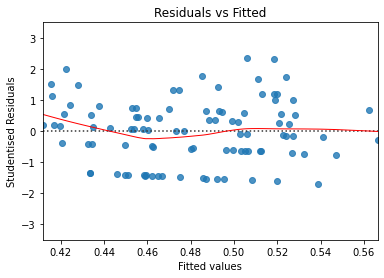

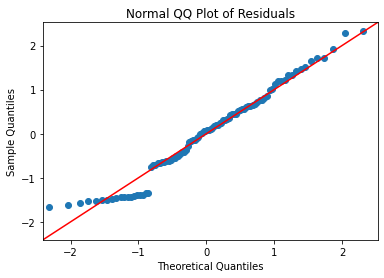

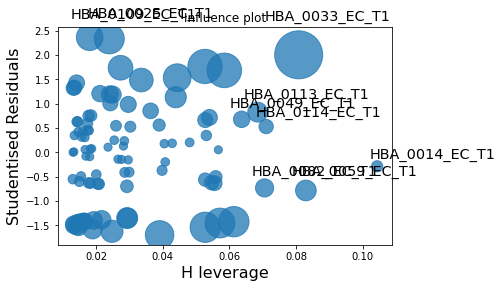

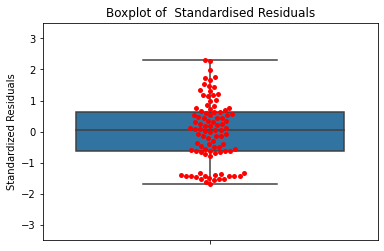

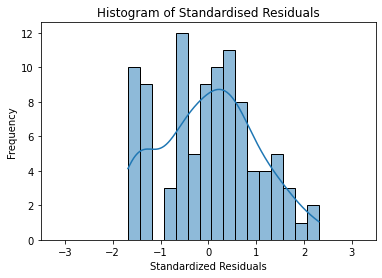

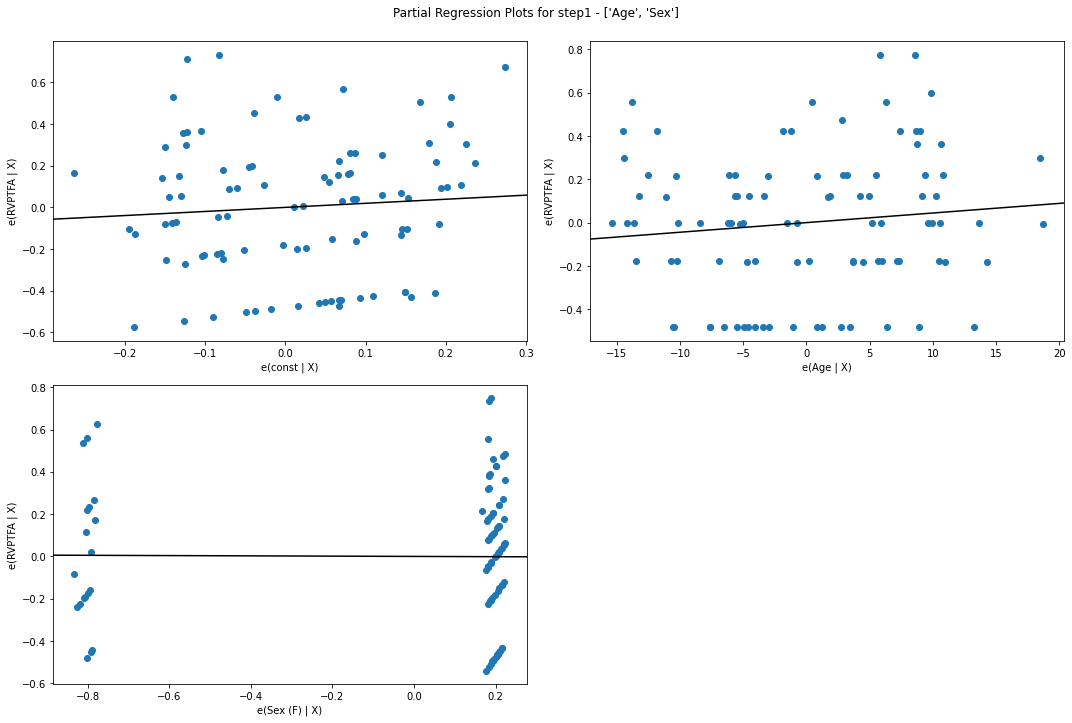

---
Diagnostic tests - step2

Independence of Residuals = PASSED (Durbin-Watson Test)
Linearity = FAILED (Non-sig. linear relationship between DV and each IV)
Linearity = PASSED (Rainbow Test)
Homoscedasticity = PASSED (Bruesch Pagan Test)
Homoscedasticity = PASSED (F-test for residual variance)
Homoscedasticity = PASSED (Goldfeld Quandt Test)
Multicollinearity = PASSED (High Pairwise correlations)
Multicollinearity = FAILED (High Variance Inflation Factor)
Outliers/Leverage/Influence = PASSED (Extreme Standardised Residuals)
Outliers/Leverage/Influence = PASSED (Large Cook's Distance)
Normality = PASSED (Mean of residuals not approx = 0)
Normality = FAILED (Shapiro-Wilk Test)
 
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Normality
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Linearity
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Multicollinearity


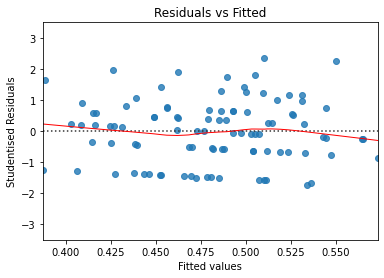

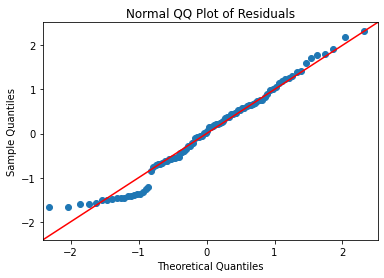

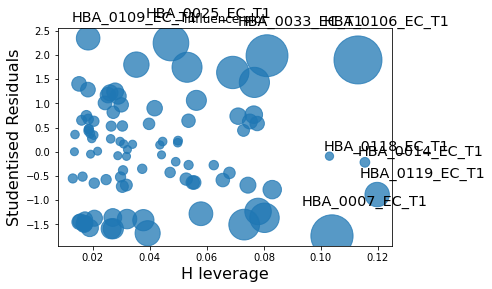

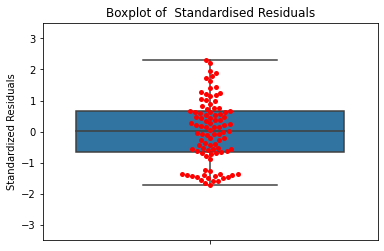

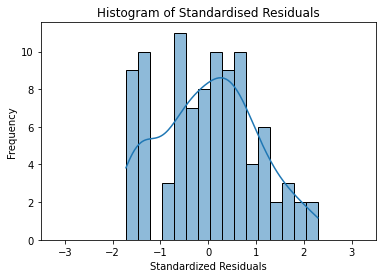

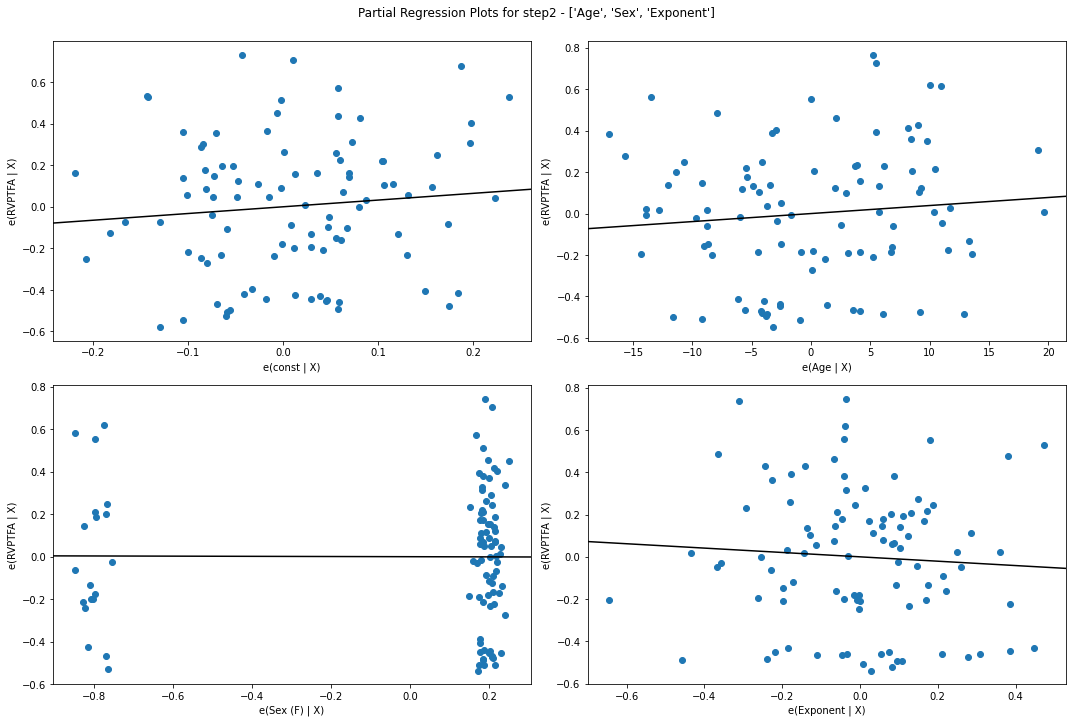

,Step,Predictors,N (observations),DF (residuals),DF (model),R-squared,F-value,P-value (F),SSE,SSTO,...,Semi-partial Correlation,Unique Variance %,Failed assumptions (check!),R-squared change,F-value change,P-value (F change),Group,Region,Outcome measure,Predictor of interest
0,1,"[Age, Sex]",96.0,93.0,2.0,0.013225,0.623186,0.538457,9.955937,10.089365,...,"{'Age': 0.114926144743707, 'Sex': -0.008093865...","{'Age': 1.3208018745651493, 'Sex': 0.006551066...","[Normality, Linearity, Multicollinearity]",NaN,NaN,NaN,EC,Global,RVPTFA,Exponent
1,2,"[Age, Sex, Exponent]",96.0,92.0,3.0,0.017558,0.548057,0.650702,9.912220,10.089365,...,"{'Age': 0.09773996461959591, 'Sex': -0.0052854...","{'Age': 0.9553100683839861, 'Sex': 0.002793606...","[Normality, Linearity, Multicollinearity]",0.004333,0.405762,0.52571,EC,Global,RVPTFA,Exponent




--------------------
Hierarchical regression - Offset predicting RVPTFA @ Global for EC
---
Diagnostic tests - step1

Independence of Residuals = PASSED (Durbin-Watson Test)
Linearity = FAILED (Non-sig. linear relationship between DV and each IV)
Linearity = PASSED (Rainbow Test)
Homoscedasticity = PASSED (Bruesch Pagan Test)
Homoscedasticity = PASSED (F-test for residual variance)
Homoscedasticity = PASSED (Goldfeld Quandt Test)
Multicollinearity = PASSED (High Pairwise correlations)
Multicollinearity = FAILED (High Variance Inflation Factor)
Outliers/Leverage/Influence = PASSED (Extreme Standardised Residuals)
Outliers/Leverage/Influence = PASSED (Large Cook's Distance)
Normality = PASSED (Mean of residuals not approx = 0)
Normality = FAILED (Shapiro-Wilk Test)
 
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Normality
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Linearity
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Multico

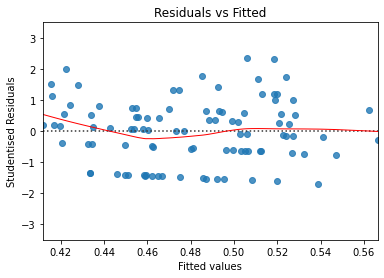

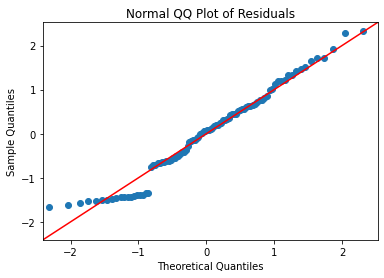

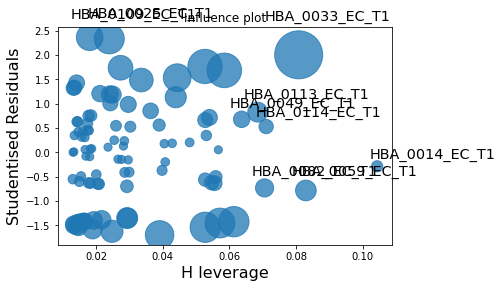

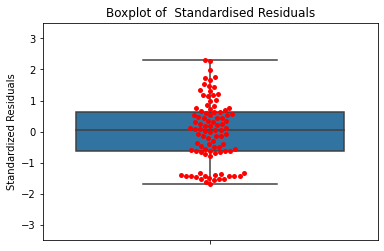

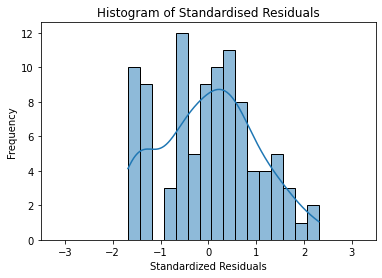

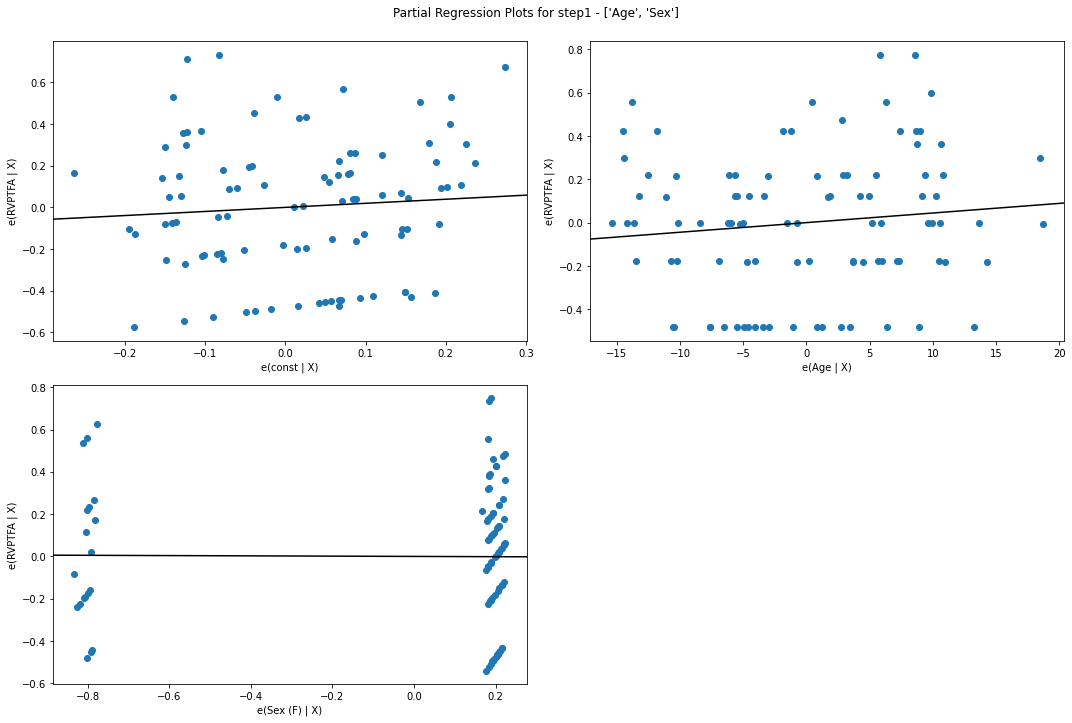

---
Diagnostic tests - step2

Independence of Residuals = PASSED (Durbin-Watson Test)
Linearity = FAILED (Non-sig. linear relationship between DV and each IV)
Linearity = PASSED (Rainbow Test)
Homoscedasticity = PASSED (Bruesch Pagan Test)
Homoscedasticity = PASSED (F-test for residual variance)
Homoscedasticity = PASSED (Goldfeld Quandt Test)
Multicollinearity = PASSED (High Pairwise correlations)
Multicollinearity = FAILED (High Variance Inflation Factor)
Outliers/Leverage/Influence = PASSED (Extreme Standardised Residuals)
Outliers/Leverage/Influence = PASSED (Large Cook's Distance)
Normality = PASSED (Mean of residuals not approx = 0)
Normality = FAILED (Shapiro-Wilk Test)
 
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Normality
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Linearity
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Multicollinearity


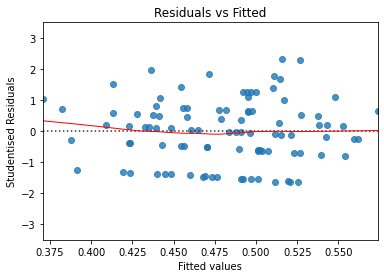

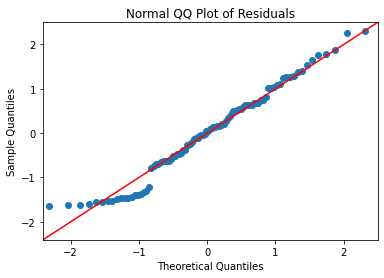

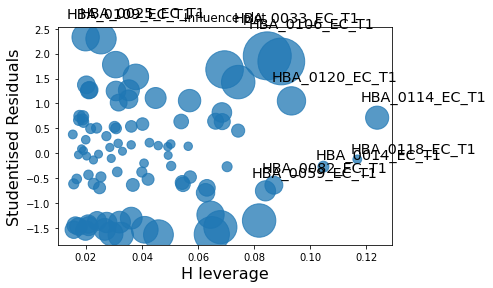

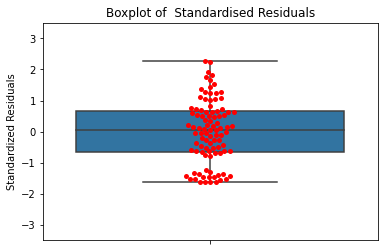

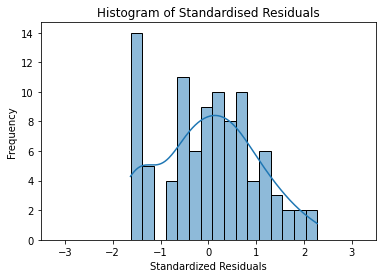

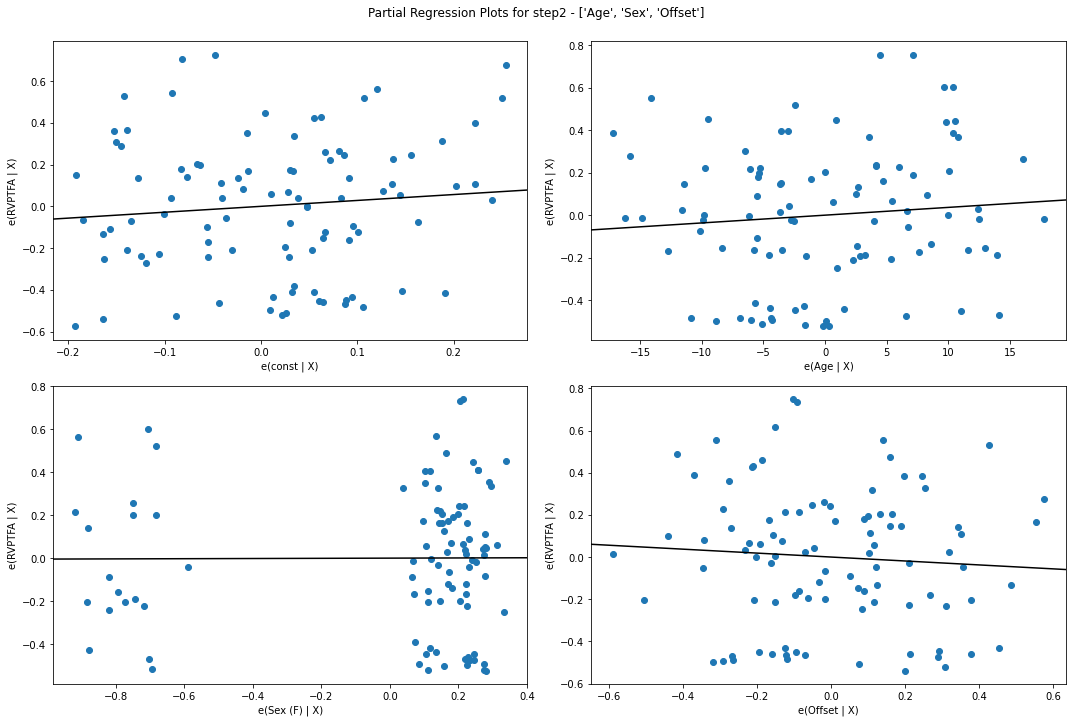

,Step,Predictors,N (observations),DF (residuals),DF (model),R-squared,F-value,P-value (F),SSE,SSTO,...,Semi-partial Correlation,Unique Variance %,Failed assumptions (check!),R-squared change,F-value change,P-value (F change),Group,Region,Outcome measure,Predictor of interest
0,1,"[Age, Sex]",96.0,93.0,2.0,0.013225,0.623186,0.538457,9.955937,10.089365,...,"{'Age': 0.114926144743707, 'Sex': -0.008093865...","{'Age': 1.3208018745651493, 'Sex': 0.006551066...","[Normality, Linearity, Multicollinearity]",NaN,NaN,NaN,EC,Global,RVPTFA,Offset
1,2,"[Age, Sex, Offset]",96.0,92.0,3.0,0.018231,0.569461,0.636521,9.905427,10.089365,...,"{'Age': 0.09125815019823136, 'Sex': 0.00526813...","{'Age': 0.8328049977602954, 'Sex': 0.002775329...","[Normality, Linearity, Multicollinearity]",0.005006,0.469126,0.495112,EC,Global,RVPTFA,Offset




--------------------
Hierarchical regression - Alpha CF predicting RVPTFA @ Global for EC
---
Diagnostic tests - step1

Independence of Residuals = PASSED (Durbin-Watson Test)
Linearity = FAILED (Non-sig. linear relationship between DV and each IV)
Linearity = PASSED (Rainbow Test)
Homoscedasticity = PASSED (Bruesch Pagan Test)
Homoscedasticity = PASSED (F-test for residual variance)
Homoscedasticity = PASSED (Goldfeld Quandt Test)
Multicollinearity = PASSED (High Pairwise correlations)
Multicollinearity = FAILED (High Variance Inflation Factor)
Outliers/Leverage/Influence = PASSED (Extreme Standardised Residuals)
Outliers/Leverage/Influence = PASSED (Large Cook's Distance)
Normality = PASSED (Mean of residuals not approx = 0)
Normality = FAILED (Shapiro-Wilk Test)
 
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Normality
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Linearity
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Multi

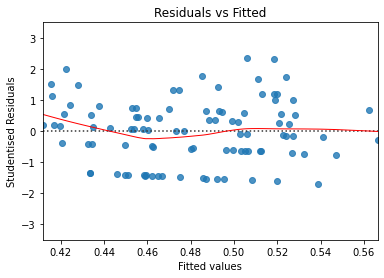

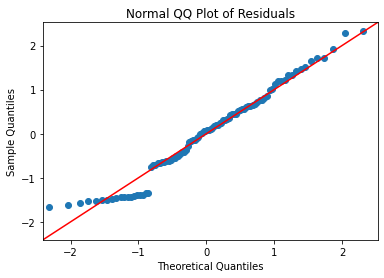

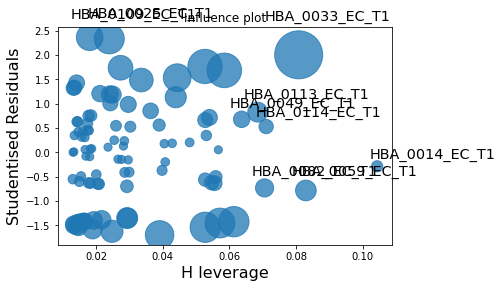

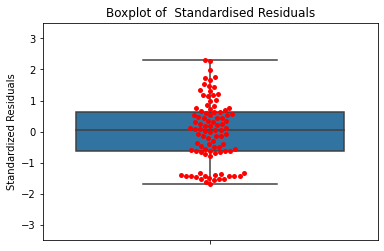

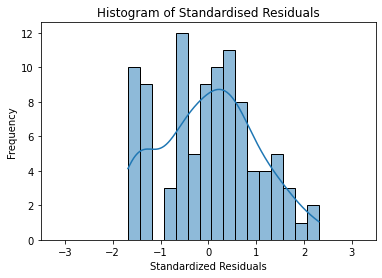

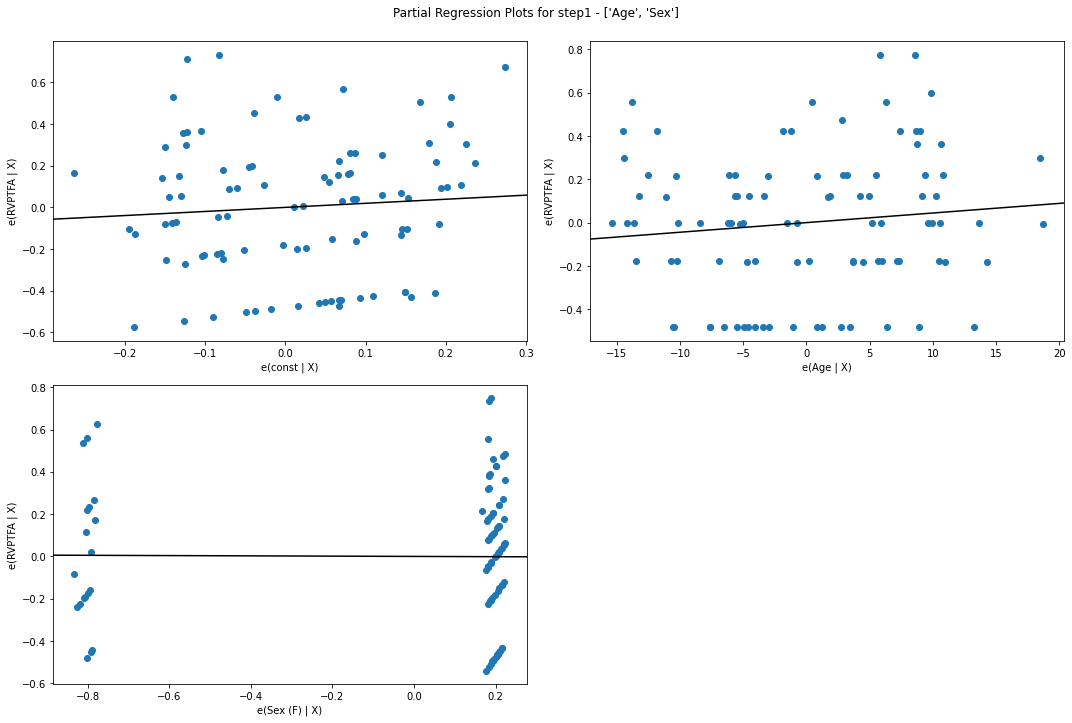

---
Diagnostic tests - step2

Independence of Residuals = PASSED (Durbin-Watson Test)
Linearity = FAILED (Non-sig. linear relationship between DV and each IV)
Linearity = PASSED (Rainbow Test)
Homoscedasticity = PASSED (Bruesch Pagan Test)
Homoscedasticity = PASSED (F-test for residual variance)
Homoscedasticity = PASSED (Goldfeld Quandt Test)
Multicollinearity = PASSED (High Pairwise correlations)
Multicollinearity = FAILED (High Variance Inflation Factor)
Outliers/Leverage/Influence = PASSED (Extreme Standardised Residuals)
Outliers/Leverage/Influence = PASSED (Large Cook's Distance)
Normality = PASSED (Mean of residuals not approx = 0)
Normality = PASSED (Shapiro-Wilk Test)
 
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Linearity
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Multicollinearity


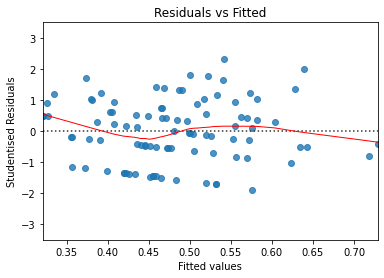

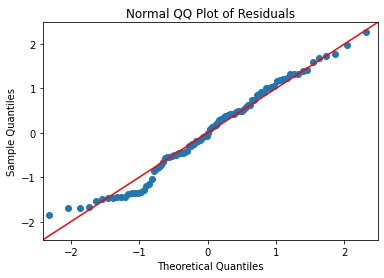

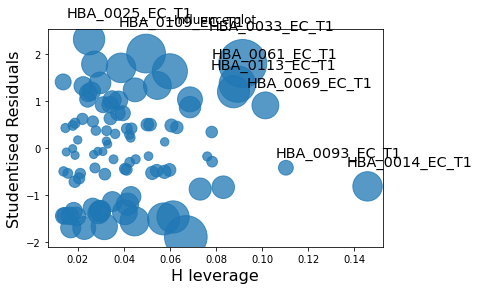

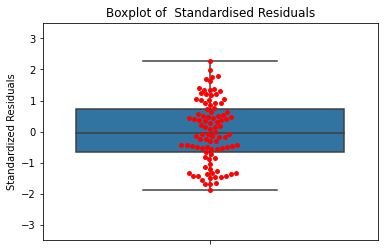

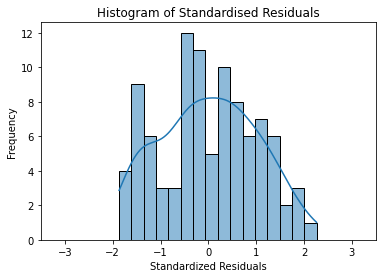

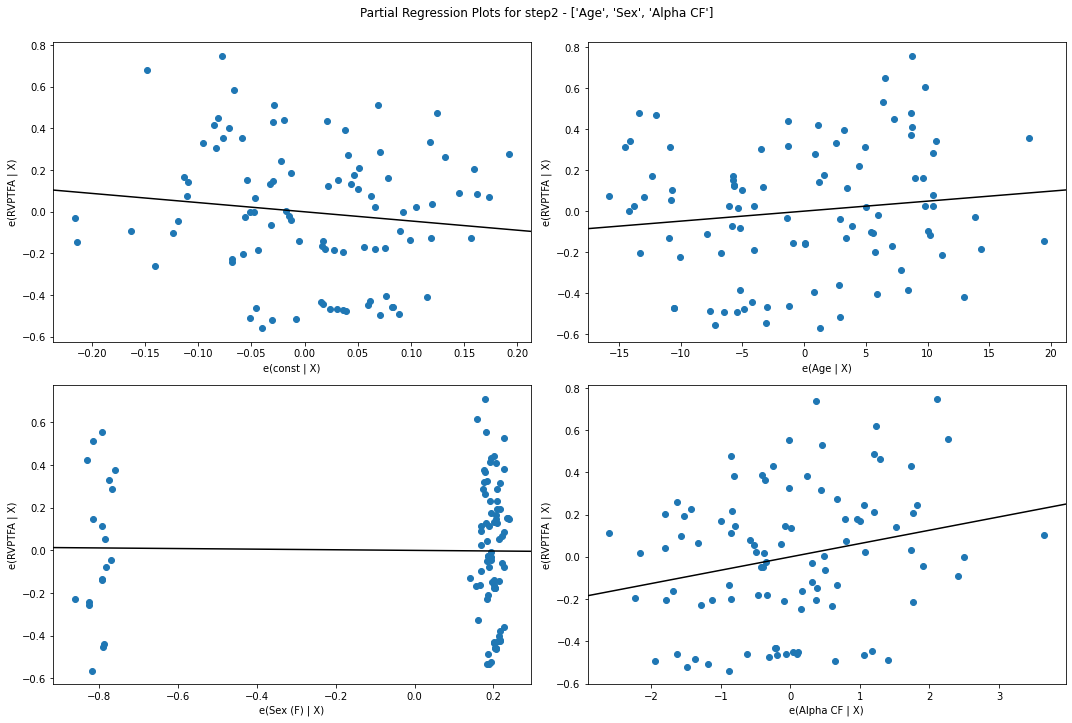

,Step,Predictors,N (observations),DF (residuals),DF (model),R-squared,F-value,P-value (F),SSE,SSTO,...,Semi-partial Correlation,Unique Variance %,Failed assumptions (check!),R-squared change,F-value change,P-value (F change),Group,Region,Outcome measure,Predictor of interest
0,1,"[Age, Sex]",96.0,93.0,2.0,0.013225,0.623186,0.538457,9.955937,10.089365,...,"{'Age': 0.114926144743707, 'Sex': -0.008093865...","{'Age': 1.3208018745651493, 'Sex': 0.006551066...","[Normality, Linearity, Multicollinearity]",NaN,NaN,NaN,EC,Global,RVPTFA,Alpha CF
1,2,"[Age, Sex, Alpha CF]",96.0,92.0,3.0,0.068632,2.259807,0.086696,9.396913,10.089365,...,"{'Age': 0.1258702683723695, 'Sex': -0.01759031...","{'Age': 1.5843324460132324, 'Sex': 0.030941904...","[Linearity, Multicollinearity]",0.055407,5.473101,0.021475,EC,Global,RVPTFA,Alpha CF




--------------------
Hierarchical regression - Alpha absolute power predicting RVPTFA @ Global for EC
---
Diagnostic tests - step1

Independence of Residuals = PASSED (Durbin-Watson Test)
Linearity = FAILED (Non-sig. linear relationship between DV and each IV)
Linearity = PASSED (Rainbow Test)
Homoscedasticity = PASSED (Bruesch Pagan Test)
Homoscedasticity = PASSED (F-test for residual variance)
Homoscedasticity = PASSED (Goldfeld Quandt Test)
Multicollinearity = PASSED (High Pairwise correlations)
Multicollinearity = FAILED (High Variance Inflation Factor)
Outliers/Leverage/Influence = PASSED (Extreme Standardised Residuals)
Outliers/Leverage/Influence = PASSED (Large Cook's Distance)
Normality = PASSED (Mean of residuals not approx = 0)
Normality = FAILED (Shapiro-Wilk Test)
 
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Normality
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Linearity
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assump

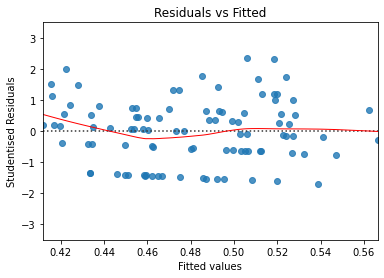

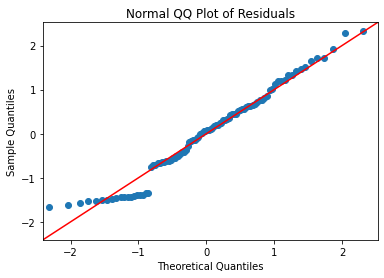

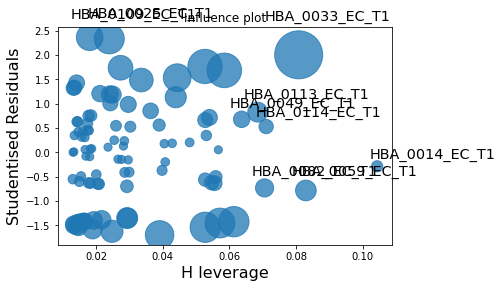

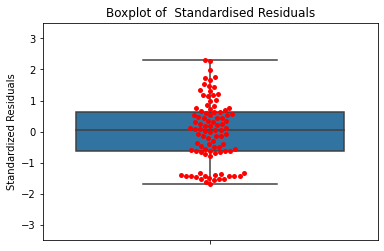

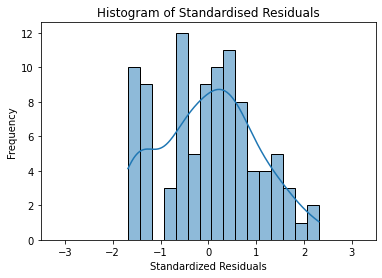

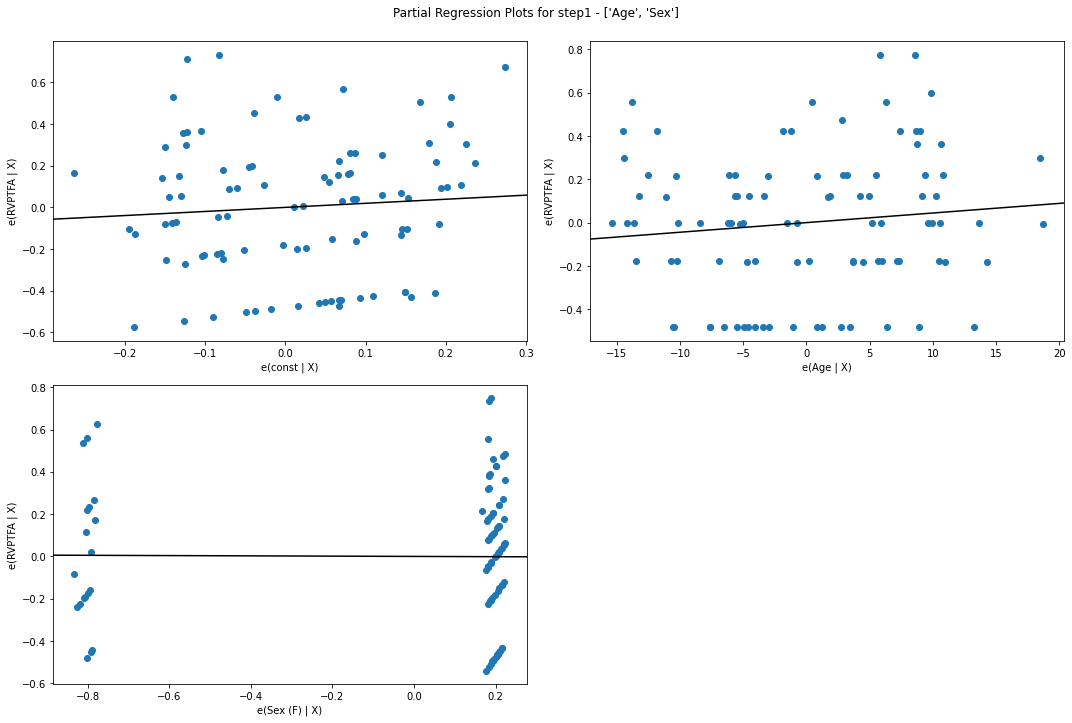

---
Diagnostic tests - step2

Independence of Residuals = PASSED (Durbin-Watson Test)
Linearity = FAILED (Non-sig. linear relationship between DV and each IV)
Linearity = PASSED (Rainbow Test)
Homoscedasticity = PASSED (Bruesch Pagan Test)
Homoscedasticity = PASSED (F-test for residual variance)
Homoscedasticity = PASSED (Goldfeld Quandt Test)
Multicollinearity = PASSED (High Pairwise correlations)
Multicollinearity = FAILED (High Variance Inflation Factor)
Outliers/Leverage/Influence = PASSED (Extreme Standardised Residuals)
Outliers/Leverage/Influence = PASSED (Large Cook's Distance)
Normality = PASSED (Mean of residuals not approx = 0)
Normality = FAILED (Shapiro-Wilk Test)
 
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Normality
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Linearity
FURTHER INSPECTION REQUIRED -> 1/2 tests passed for assumption - Multicollinearity


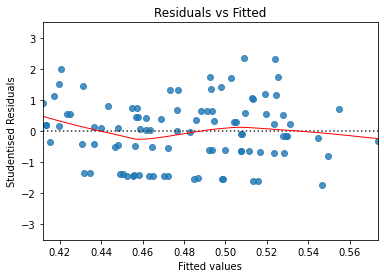

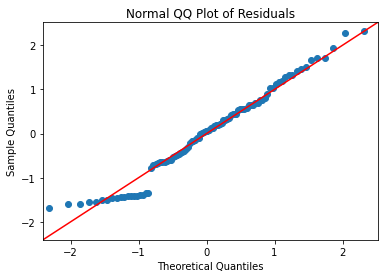

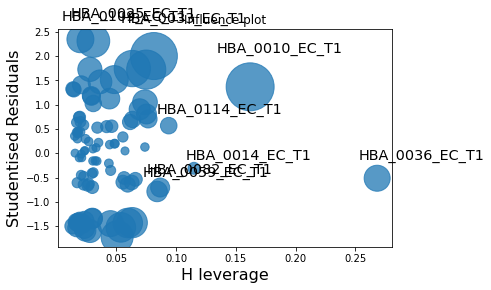

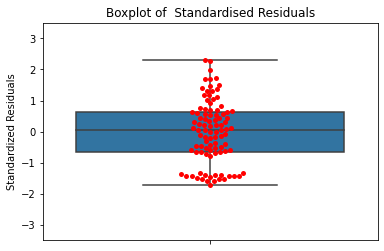

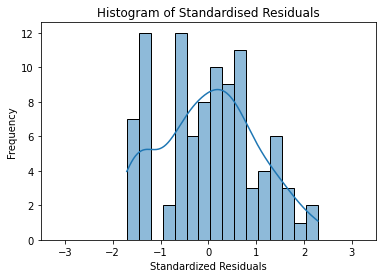

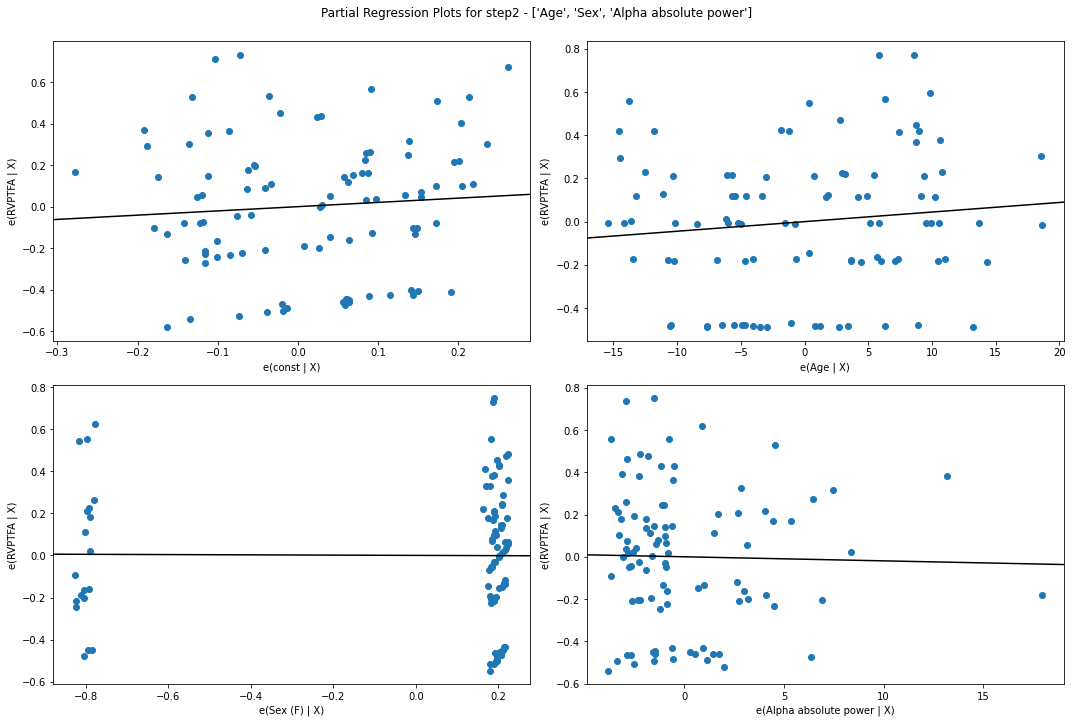

,Step,Predictors,N (observations),DF (residuals),DF (model),R-squared,F-value,P-value (F),SSE,SSTO,...,Semi-partial Correlation,Unique Variance %,Failed assumptions (check!),R-squared change,F-value change,P-value (F change),Group,Region,Outcome measure,Predictor of interest
0,1,"[Age, Sex]",96.0,93.0,2.0,0.013225,0.623186,0.538457,9.955937,10.089365,...,"{'Age': 0.114926144743707, 'Sex': -0.008093865...","{'Age': 1.3208018745651493, 'Sex': 0.006551066...","[Normality, Linearity, Multicollinearity]",NaN,NaN,NaN,EC,Global,RVPTFA,Alpha absolute power
1,2,"[Age, Sex, Alpha absolute power]",96.0,92.0,3.0,0.013688,0.425597,0.735110,9.951260,10.089365,...,"{'Age': 0.11486461187795306, 'Sex': -0.0078449...","{'Age': 1.3193879061872795, 'Sex': 0.006154306...","[Normality, Linearity, Multicollinearity]",0.000464,0.043242,0.83573,EC,Global,RVPTFA,Alpha absolute power


In [30]:
predictors = ['Exponent', 'Offset', 'Alpha CF', 'Alpha absolute power']
outcome = 'RVPTFA'
diagnostics = True

for predictor in predictors:
    results = pd.DataFrame()
    for r, region in enumerate(regions):

        # Concatenate demographics/PAL data with EEG measures for the region of the interest
        data = pd.concat([eeg_data[eeg_data['Region']==region], democog_data], axis=1)

        # Run HLR for both groups
        results_grp = pd.DataFrame()
        for g, group in enumerate(groups):
            if diagnostics ==True: print('\n\n--------------------\nHierarchical regression -',predictor,'predicting',outcome,'@',region,'for',group)

            grp_data = data[data['Group']==group]

            # List of dataframes of predictor variables for each step
            X = [grp_data[['Age', 'Sex (F)']],
                grp_data[['Age', 'Sex (F)', predictor]]]

            # List of predictor variable names for each step
            X_names = [['Age', 'Sex'], 
                    ['Age', 'Sex', predictor]]

            # Outcome variable as dataframe
            y = grp_data[[outcome]]

            # Create a HLR model with diagnostic tests, run and save the results
            model = HLR.HLR_model(diagnostics=diagnostics, showfig=True, save_folder='results/{}'.format(predictor), verbose=True)
            results_temp, reg_models = model.run(X=X, X_names=X_names, y=y)
            #model.save_results(filename='labs-leisure_results', show_results=True)
        
            # Modify the results dataframe by adding region and outcome measure and concat to master dataframe
            results_temp['Group'] = group
            results_temp['Region'] = region
            results_temp['Outcome measure'] = outcome
            results_temp['Predictor of interest'] = predictor
            results_grp = pd.concat([results_grp, results_temp]).reset_index(drop=True)
        results = pd.concat([results, results_grp]).reset_index(drop=True)

    display(results)
    try:
        os.makedirs('{}/HLR/{}/'.format(savefinal_folder, predictor))
    except FileExistsError:
        pass
    results.to_excel('{}/HLR/{}/HLR_results_predictor={}_outcome={}.xlsx'.format(savefinal_folder,
                                                                                 predictor,
                                                                                 predictor,
                                                                                 outcome))

In [ ]:
predictors = ['Exponent', 'Offset', 'Alpha CF', 'Alpha absolute power']
outcome = 'RVPTFA'
diagnostics = True

for predictor in predictors:
    results = pd.DataFrame()
    for r, region in enumerate(regions):

        # Concatenate demographics/PAL data with EEG measures for the region of the interest
        data = pd.concat([eeg_data[eeg_data['Region']==region], democog_data], axis=1)

        # Run HLR for both groups
        results_grp = pd.DataFrame()
        for g, group in enumerate(groups):
            if diagnostics ==True: print('\n\n--------------------\nHierarchical regression -',predictor,'predicting',outcome,'@',region,'for',group)

            grp_data = data[data['Group']==group]

            # List of dataframes of predictor variables for each step
            X = [grp_data[['Age', 'Sex (F)']],
                grp_data[['Age', 'Sex (F)', predictor]]]

            # List of predictor variable names for each step
            X_names = [['Age', 'Sex'], 
                    ['Age', 'Sex', predictor]]

            # Outcome variable as dataframe
            y = grp_data[[outcome]]

            # Create a HLR model with diagnostic tests, run and save the results
            model = HLR.HLR_model(diagnostics=diagnostics, showfig=True, save_folder='results/{}'.format(predictor), verbose=True)
            results_temp, reg_models = model.run(X=X, X_names=X_names, y=y)
            #model.save_results(filename='labs-leisure_results', show_results=True)
        
            # Modify the results dataframe by adding region and outcome measure and concat to master dataframe
            results_temp['Group'] = group
            results_temp['Region'] = region
            results_temp['Outcome measure'] = outcome
            results_temp['Predictor of interest'] = predictor
            results_grp = pd.concat([results_grp, results_temp]).reset_index(drop=True)
        results = pd.concat([results, results_grp]).reset_index(drop=True)

    display(results)
    try:
        os.makedirs('{}/HLR/{}/'.format(savefinal_folder, predictor))
    except FileExistsError:
        pass
    results.to_excel('{}/HLR/{}/HLR_results_predictor={}_outcome={}.xlsx'.format(savefinal_folder,
                                                                                 predictor,
                                                                                 predictor,
                                                                                 outcome))